In [1]:
import Pkg
Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


In [2]:
using JET

In [3]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads, Test

Precompiling packages...
  13180.7 ms  ✓ BackAction
  1 dependency successfully precompiled in 17 seconds. 285 already precompiled.


# Checking Step by Step

## Check the convergence to the average by direct evaluation of the observables

In [4]:
# Parameters and time evaluation
params = SimulParameters([1.0+0im; 0.0], #initial condition
    300.0, #tf
    1, # seed
    3_000, # Number of trajectories
    # You can ignore the rest, they are only used for the Gillipsie method
    25_000, # Number of samples in the finegrid
    4.0, # Multiplier to use in the fine grid
    1e-3 # Tolerance for passing Dark state test
)
nsaves = 100
saveat = collect(LinRange(0.0, params.tf, nsaves));
ntimeseval = 2000
t_eval = collect(LinRange(0.0, params.tf, ntimeseval))
gamma = 1.0
delta = 0.5
omega = 0.5

H = 0.5*delta*BackAction.sigma_z + 0.5*omega*BackAction.sigma_x
L = sqrt(gamma)*BackAction.sigma_m

sys = System(H, [L])
# Analytical solution

sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]
u0 = zeros(Float64, 3)
for k in 1:3
    u0[k] = real(dot(params.psi0, sigma[k], params.psi0))
end
function resonance_fluorescene!(du, u, p, t)
    du[1] = - 0.5*gamma*u[1] - delta*u[2]  
    du[2] = + delta*u[1] - 0.5*gamma*u[2]- omega*u[3]  
    du[3] = omega*u[2] - gamma*u[3] - gamma
end
prob_analytical = ODEProblem(resonance_fluorescene!, u0, extrema(saveat))
sol_analytical = solve(prob_analytical);

In [5]:
@time begin
sim = get_sol_jumps(sys, params, saveat; reltol=1e-8);
end 

LoadError: UndefVarError: `get_sol_jumps` not defined

In [9]:
isconcretetype(Union{Vector{ComplexF64}, Matrix{ComplexF64}})

false

In [12]:
eltype(t_eval)

Float64

In [5]:
rng = Random.Xoshiro()
Random.seed!(rng, 10)
@report_opt begin

 BackAction._LindbladJump(
            sys.Ls,
            sys.LLs,
            sys.Heff,
            rng,
            Ref(rand(rng)),
            similar(t_eval, sys.NCHANNELS),
            similar(t_eval, sys.NCHANNELS),
            similar(params.psi0),
        Vector{Float64}(undef, BackAction.JUMP_TIMES_INIT_SIZE),
        Vector{Int64}(undef, BackAction.JUMP_TIMES_INIT_SIZE),
        Ref(1)
        )
end

LoadError: expression is not a function call, or is too complex for @report_opt to analyze; break it down to simpler parts if possible. In some cases, you may want to use Meta.@lower.

In [19]:
isconcretetype(t_eval)

false

In [ ]:
@report_opt get_sol_jumps(sys, params, t_eval)

┌ Warning: Tuple{DiffEqBase.var"##solve#46", Base.Pairs{Symbol, V, Tuple{Vararg{Symbol, N}}, NamedTuple{names, T}} where {V, N, names, T<:Tuple{Vararg{Any, N}}}, typeof(solve), EnsembleProblem, Vararg{Any}} was not found
└ @ Revise ~/.julia/packages/Revise/mLfYT/src/packagedef.jl:1181
[ Info: tracking Base
┌ Warning: Tuple{SciMLBase.var"#679#680"} was not found
└ @ Revise ~/.julia/packages/Revise/mLfYT/src/packagedef.jl:1181
┌ Warning: Tuple{SciMLBase.var"#690#691", Any} was not found
└ @ Revise ~/.julia/packages/Revise/mLfYT/src/packagedef.jl:1181
┌ Warning: Tuple{DiffEqBase.var"##solve#42", Any, Any, Any, Any, Base.Pairs{Symbol, V, Tuple{Vararg{Symbol, N}}, NamedTuple{names, T}} where {V, N, names, T<:Tuple{Vararg{Any, N}}}, typeof(solve), SciMLBase.AbstractDEProblem, Vararg{Any}} was not found
└ @ Revise ~/.julia/packages/Revise/mLfYT/src/packagedef.jl:1181
┌ Warning: Tuple{DiffEqBase.var"##solve_up#44", Base.Pairs{Symbol, V, Tuple{Vararg{Symbol, N}}, NamedTuple{names, T}} where {V,

In [7]:
isconcretetype(ODEProblem)

false

In [10]:
# Obtain the observables
r_sample = Array{Float64}(undef, 3, ntimeseval, params.ntraj)
@threads for n in 1:params.ntraj
    for t in 1:ntimeseval
        for k in 1:3
            r_sample[k, t, n] = real(dot(sim[n](t_eval[t]), sigma[k], sim[n](t_eval[t])))/dot(sim[n](t_eval[t]), sim[n](t_eval[t]))
        end
    end
end

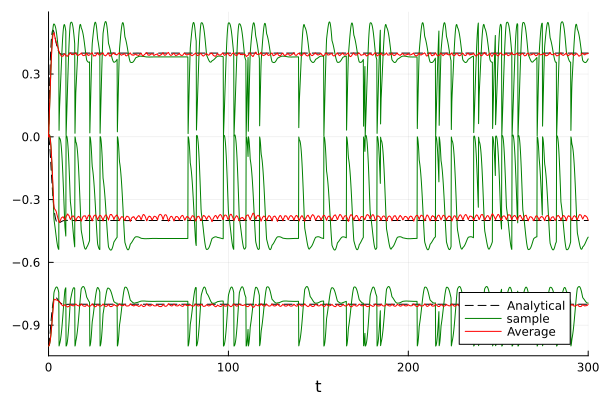

In [11]:
# Analytical
plot(sol_analytical, idxs=(0,3), label="Analytical", color="black", line=:dash)
plot!(sol_analytical, idxs=(0,2), label=false, color="black", line=:dash)
plot!(sol_analytical, idxs=(0,1), label=false, color="black", line=:dash)
# Sample
plot!(t_eval, r_sample[1, :, end], label="sample", color="green")
plot!(t_eval, r_sample[2, :, end], label=false, color="green")
plot!(t_eval, r_sample[3, :, end], label=false, color="green")
# Average
plot!(t_eval, dropdims(mean(r_sample[1, :, :], dims=2), dims=2), label="Average", color="red")
plot!(t_eval, dropdims(mean(r_sample[3, :, :], dims=2), dims=2), label=false, color="red")
plot!(t_eval, dropdims(mean(r_sample[2, :, :], dims=2), dims=2), label=false, color="red")

## Check convergence to the average by trajectory extraction 

In [ ]:
trajectories = Vector{Trajectory}(undef, params.ntraj)
for k in 1:params.ntraj
    trajectories[k] = extract_trajectory(sim[k])
end

In [ ]:
@testset "Resonance Fluorescene: Expectation Value Convergence" begin
    ntimes = length(t_eval)
    sample = zeros(ComplexF64,  sys.NLEVELS, ntimes, params.ntraj) # states

    for n in 1:params.ntraj
        states = BackAction.states_att(t_eval, trajectories[n], sys,  params.psi0)
        sample[:, :, n] = states[:, :]
    end
    # Obtain the value of the observables
    r_sample = zeros(Float64, ntimes, 3, params.ntraj)
    sigma = [BackAction.sigma_x, BackAction.sigma_y, BackAction.sigma_z]

    for j in 1:params.ntraj
        for k in 1:3
            for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[:, tn, j], sigma[k], sample[:, tn, j])   # Drop the extra dimension
            end
        end
    end
    r_avg = dropdims(mean(r_sample, dims=3), dims=3) # Ensemble average


    # System of equations for RF (Source: Wiseman section 3.3.1)
    function f_resonancefluorescene(t, r)
        return [-0.5*gamma*r[1] - 2*delta*r[2]; 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3];
                2*omega*r[2] - gamma*(r[3] + 1)]
    end

    for k in 1:ntimes
        @test abs(sol_analytical(t_eval[k])[1] - r_avg[k, 1]) < 0.1
        @test abs(sol_analytical(t_eval[k])[2] - r_avg[k, 2]) < 0.1
        @test abs(sol_analytical(t_eval[k])[3] - r_avg[k, 3]) < 0.1
    end
end



# Checking FI

In [ ]:
# Trajectory extraction
"From the solution, obtain the trajectory"
function extract_trajectory(sol)
    times = sol.prob.kwargs[:callback].affect!.jump_times
    channels = sol.prob.kwargs[:callback].affect!.jump_channels
    njumps = length(times)
    traj = Vector{DetectionClick}(undef, njumps)
    traj[1] = DetectionClick(times[1], channels[1]) 
    @inbounds for k in 2:njumps   
       traj[k] = DetectionClick(times[k] - times[k-1], channels[k]) 
    end  
    return traj
end

In [3]:
# Set up the unravelings
function sample_c2(seed)
    theta = pi*rand()
    phi = 2*pi*rand()
    return [cos(theta*0.5); exp(1im*phi)*sin(theta*0.5)] 
end
function get_random_unraveling(seed)
    Random.seed!(seed)
    T = sample_c2(seed) 
    T = reshape(T/norm(T), 2,1)
    T_curvy = [real(T[1]) imag(T[1]); real(T[2]) imag(T[2]) ]
    F = svd(T_curvy) # Factorization object
    P = F.V * Diagonal(F.S) * F.Vt
    O = F.U * F.Vt
    T_curvy_dyne = O' * T_curvy
    T_dyne = O' * real.(T) + 1im * O' * imag.(T)
    Ta = T 
    Tb = T_dyne 
    Tc = T_dyne 
    Ts = Dict([("a", Ta), ("b", Tb), ("c", Tc)]) # Dictionary with the Ts
    alpha0 = [0.5 + 0im; 0.5 + 0im] 
    alphas = Dict([("a", alpha0), ("b", alpha0), ("c", O' * alpha0)]) # Dictionary with the alphas

    return Ts, alphas
end


get_random_unraveling (generic function with 1 method)

In [4]:
Ts = [1.0 + 0im]
alphas = collect(LinRange(0.0, 2.0, 30));

In [2]:
21* 2.0/30

1.4

In [5]:
delta_gammelmark = 0.2/0.478 * [0.146,0.262,0.383,0.511,0.648,0.806,0.965,1.118,1.287,1.438,1.596,
                                1.755,1.888, 2.057, 2.206, 2.381, 2.539, 2.682, 2.865, 3.013, 3.174, 3.334, 3.452]
fi_t_gammelmark = [0.115, 0.221, 0.338, 0.425, 0.507, 0.557, 0.573, 0.566, 0.532, 0.494,
                   0.448, 0.403, 0.363, 0.318, 0.281, 0.241, 0.210, 0.186, 0.156, 0.137, 0.115, 0.101, 0.09348];

In [6]:
# Base parametric operators
H0 = (delta::Float64, omega::Float64, k::Float64) ->  delta*[[0, 0] [0, 1.0+0im]]  + 0.5*omega*BackAction.sigma_x
L0 = (delta::Float64, omega::Float64, k::Float64) -> sqrt(k)*BackAction.sigma_m
# Unraveling parametrix operators
function obtain_parametric_unraveling_operators(T, alpha)
    nchannels, jmax = size(T)
    njumps_original = 1 #number of original jump
    Ls_new = [(delta, omega, k) -> (sum(T[i, j] * L0(delta, omega, k) for j in 1:njumps_original) + alpha[i]*I) for i in 1:nchannels]
    J = (delta, omega, k) -> sum(conj(alpha[i])*Ls_new[i](delta, omega, k)-alpha[i]*adjoint(Ls_new[i](delta, omega, k)) for i in 1:nchannels)
    H = (delta, omega, k) -> H0(delta, omega, k) - 0.5im * J(delta, omega, k)
                               
    He = BackAction.getheff_parametrized(H, Ls_new)
    return Ls_new, H, He
end


obtain_parametric_unraveling_operators (generic function with 1 method)

In [ ]:
delta = delta_gammelmark[1]
T = reshape([1.0 + 0im], 1,1)
alpha = [0.0 + 0im]
Ls, H, He = obtain_parametric_unraveling_operators(T, alpha)
 omega = 1.0
 k = 0.5
 sys = System(H(delta, omega, k), # Hamiltonian
              [L(delta, omega, k) for L in Ls], # jump
             )
 tf = 300.0
 ntraj = 1000
 params = SimulParameters(BackAction.rf_psi0,
                          tf, # Final time. Set very long so that all trajectories jump
                          1, # seed
                          ntraj, # Number of trajectories
                          30_000, # Number of samples in the finegrid
                          1.0, # Multiplier to use in the fine grid
                          1e-3 # Tolerance for passing Dark state test
                          )
 nsaves = 100
 saveat = collect(LinRange(0.0, params.tf, nsaves));
 
 @time begin
     sim = get_sol_jumps(sys, params, saveat; reltol=1e-8);
 end 
 trajectories =  Vector{Trajectory}(undef, params.ntraj)
  for k in 1:params.ntraj
        trajectories[k] = extract_trajectory(sim[k])
    end

In [9]:
function GetFI(delta; T = reshape([1.0 + 0im], 1,1), alpha = [0.0 + 0im])
# System and parameters
    Ls, H, He = obtain_parametric_unraveling_operators(T, alpha)
    omega = 1.0
    k = 0.5
    sys = System(H(delta, omega, k), # Hamiltonian
                 [L(delta, omega, k) for L in Ls], # jump
                )
    tf = 300.0
    ntraj = 3000
    params = SimulParameters(BackAction.rf_psi0,
                             tf, # Final time. Set very long so that all trajectories jump
                             1, # seed
                             ntraj, # Number of trajectories
                             30_000, # Number of samples in the finegrid
                             1.0, # Multiplier to use in the fine grid
                             1e-3 # Tolerance for passing Dark state test
                             )
    nsaves = 100
    saveat = collect(LinRange(0.0, params.tf, nsaves));
    
    @time begin
        sim = get_sol_jumps(sys, params, saveat; reltol=1e-8);
    end 
    trajectories =  Vector{Trajectory}(undef, params.ntraj)
    for k in 1:params.ntraj
        trajectories[k] = extract_trajectory(sim[k])
    end
    t_given = [tf];
    ntimes = size(t_given)[1]
    xi_sample = Array{ComplexF64}(undef, sys.NLEVELS, sys.NLEVELS, ntimes, params.ntraj)
    @threads for n in 1:params.ntraj
        xi_sample[:, :, :, n] = monitoringoperator(t_given, sys, He, Ls, trajectories[n],
                                                   params.psi0,[delta, omega, k], [delta/100, 0.0, 0.0])
    end
    fi_sample = Array{Float64}(undef, ntimes, params.ntraj)
    for n in 1:params.ntraj
        for k in 1:ntimes
            fi_sample[k, n] = real(tr(xi_sample[:, :, k, n])^2)
        end
    end
    return mean(fi_sample, dims=2)[1]/tf
end

GetFI (generic function with 1 method)

In [8]:
nalphas = length(alphas)
fis = Array{Float64}(undef, nalphas, 4);

In [ ]:
for d in 1:3
    println(d)
    for k in 1:nalphas
        fis[k, d] = GetFI(delta_gammelmark[4*d]; alpha = [alphas[k]])
    end
end

1
 43.972037 seconds (906.56 M allocations: 77.320 GiB, 32.95% gc time, 37.40% compilation time)
 36.637739 seconds (884.51 M allocations: 75.662 GiB, 41.00% gc time)
 33.969543 seconds (875.33 M allocations: 74.884 GiB, 40.63% gc time)
 35.293130 seconds (869.41 M allocations: 74.391 GiB, 42.66% gc time)
 34.838025 seconds (876.03 M allocations: 74.958 GiB, 42.82% gc time)
 36.114648 seconds (901.47 M allocations: 77.130 GiB, 42.22% gc time)
 38.310570 seconds (946.87 M allocations: 81.003 GiB, 41.72% gc time)
 39.136346 seconds (1.01 G allocations: 86.614 GiB, 40.82% gc time)
 43.979136 seconds (1.09 G allocations: 93.409 GiB, 42.87% gc time)
 48.740272 seconds (1.18 G allocations: 101.269 GiB, 43.04% gc time)
 52.980042 seconds (1.29 G allocations: 110.202 GiB, 41.60% gc time)
 57.379177 seconds (1.40 G allocations: 119.920 GiB, 40.55% gc time)
 62.744509 seconds (1.53 G allocations: 130.670 GiB, 43.99% gc time)
 69.065224 seconds (1.67 G allocations: 142.479 GiB, 42.91% gc time)
 7

In [17]:
y_bound = [ 0.5549738219895288 ,0.5445026178010471 ,0.5916230366492147 ,0.6282722513089005 ,0.675392670157068
    ,0.7382198952879582 ,0.8272251308900525 ,0.8638743455497383 ,0.8848167539267017 ,0.8481675392670157 ,0.7958115183246074 ,
    0.7277486910994765 ,0.6701570680628273 ,0.5916230366492147 ,0.5287958115183247 ,0.47643979057591623 ,0.4136125654450262 ,
    0.3717277486910995 ,0.3089005235602094 ,0.2879581151832461 ,0.25654450261780104 ,0.22513089005235604 ,0.193717277486911 ,0.18848167539267016]

x_bound = [0.06282051282051282, 0.022435897435897433,0.10096153846153845, 0.13685897435897434, 0.175, 0.675392670157068,
0.22435897435897434, 
0.30288461538461536, 
0.35, 0.8638743455497383,
0.4330128205128205,
0.5541666666666666,
0.6192307692307691,
0.6887820512820513,
0.7471153846153845,
0.8233974358974359,
0.8839743589743589,
0.9423076923076923,
1.014102564102564, 
1.0612179487179487,
1.1509615384615384,
1.2048076923076922,
1.251923076923077, 
1.3192307692307692,
1.3798076923076923,
1.433653846153846]

26-element Vector{Float64}:
 0.06282051282051282
 0.022435897435897433
 0.10096153846153845
 0.13685897435897434
 0.175
 0.675392670157068
 0.22435897435897434
 0.30288461538461536
 0.35
 0.8638743455497383
 0.4330128205128205
 0.5541666666666666
 0.6192307692307691
 0.6887820512820513
 0.7471153846153845
 0.8233974358974359
 0.8839743589743589
 0.9423076923076923
 1.014102564102564
 1.0612179487179487
 1.1509615384615384
 1.2048076923076922
 1.251923076923077
 1.3192307692307692
 1.3798076923076923
 1.433653846153846

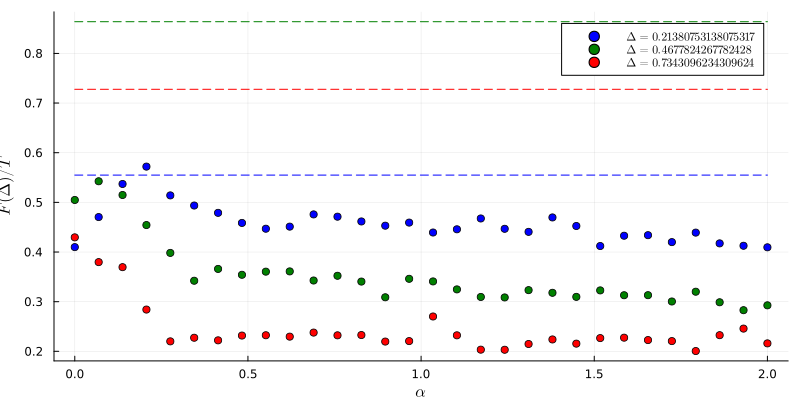

In [28]:
scatter(alphas, fis[:, 1], color="blue", label=L"\Delta=%$(delta_gammelmark[4])",xlabel=L"\alpha", ylabel=L"F(\Delta) / T")
scatter!(alphas, fis[:, 2], color="green", label=L"\Delta=%$(delta_gammelmark[4*2])",xlabel=L"\alpha", ylabel=L"F(\Delta) / T")
scatter!(alphas, fis[:, 3], color="red", label=L"\Delta=%$(delta_gammelmark[4*3])",xlabel=L"\alpha", ylabel=L"F(\Delta) / T")

plot!([alphas[1], alphas[end]], [y_bound[1], y_bound[1]], label=false, color="blue", line=:dash)
plot!([alphas[1], alphas[end]], [y_bound[4*2], y_bound[4*2]], label=false, color="green", line=:dash)
plot!([alphas[1], alphas[end]], [y_bound[4*3], y_bound[4*3]], label=false, color="red", line=:dash, size=(800, 400), legend=:topright)

#scatter!(delta_gammelmark, stepbystepfi_0, label=L"\alpha=0", color="blue", )
#scatter!(delta_gammelmark, stepbystepfi_a, label=L"T_a", color="green", )
#scatter!(delta_gammelmark, stepbystepfi_b, label=L"T_b", color="red", )
#scatter!(delta_gammelmark, stepbystepfi_c, label=L"T_c", color="yellow", title="Fisher Information, T=300", xlabel="t", ylabel=L"F(\Delta) / T")

In [44]:
using Pkg
Pkg.add(["CSV", "DataFrames"])


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed InvertedIndices ──── v1.3.1
   Installed SentinelArrays ───── v1.4.8
   Installed PrettyTables ─────── v2.4.0
   Installed InlineStrings ────── v1.4.3
   Installed WeakRefStrings ───── v1.4.2
   Installed WorkerUtilities ──── v1.6.1
   Installed DataFrames ───────── v1.7.0
   Installed PooledArrays ─────── v1.4.3
   Installed FilePathsBase ────── v0.9.24
   Installed StringManipulation ─ v0.4.1
   Installed CSV ──────────────── v0.10.15
    Updating `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks/Project.toml`
  [336ed68f] + CSV v0.10.15
  [a93c6f00] + DataFrames v1.7.0
    Updating `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks/Manifest.toml`
  [336ed68f] + CSV v0.10.15
  [a8cc5b0e] + Crayons v4.1.1
  [a93c6f00] + DataFrames v1.7.0
  [48062228] + FilePathsBase v0.9.24
  [842dd82b] + InlineStrings v1.4.3
  [41ab1584] + InvertedIndices v1.3.1
  [

In [48]:
using CSV, DataFrames

# Convert to DataFrame
df0 = DataFrame(column_name = stepbystepfi_c )
CSV.write("datac.csv", df0)


"datac.csv"